## Importações e Carregamento dos Dados

In [1]:
%pip install -q numpy -q scikit-learn -q matplotlib -q seaborn -q shap

Note: you may need to restart the kernel to use updated packages.


Neste bloco, importamos todas as bibliotecas necessárias e carregamos os dados de treino e teste. Também exibimos informações básicas sobre o dataset de treino.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from utils.functions import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
try:
    df = pd.read_parquet('data/train.parquet')
    test = pd.read_parquet('data/test.parquet')
except FileNotFoundError:
    print("Erro: Arquivos de dados não encontrados. Verifique se os arquivos estão no diretório correto.")
    exit()

print("Informações do Dataset:")
print(df.info())

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152038 entries, 0 to 152037
Data columns (total 62 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      151333 non-null  float64
 1   x1      152037 non-null  float64
 2   x2      152037 non-null  float64
 3   x3      71762 non-null   float64
 4   x4      152037 non-null  float64
 5   x5      152037 non-null  float64
 6   x6      146648 non-null  float64
 7   x7      152037 non-null  float64
 8   x8      149891 non-null  float64
 9   x9      147583 non-null  float64
 10  x10     151937 non-null  float64
 11  x11     71762 non-null   float64
 12  x12     151333 non-null  float64
 13  x13     151937 non-null  float64
 14  x14     152037 non-null  float64
 15  x15     149943 non-null  float64
 16  x16     71762 non-null   float64
 17  x17     152037 non-null  float64
 18  x18     146412 non-null  float64
 19  x19     151333 non-null  float64
 20  x20     151876 non-null 

## Criação de Amostra e Análise Inicial

Aqui, criamos uma amostra com 10% dos dados de cada classe para análises iniciais. Exibimos a distribuição das classes na amostra e criamos uma matriz de correlação para visualizar as relações entre as variáveis.

In [4]:
df_limpo, tratamentos_aplicados = analisar_e_tratar_nulos(df)

for coluna, info in tratamentos_aplicados.items():
    print(f"Coluna: {coluna}")
    print(f"Método: {info['metodo']}")
    print(f"Valor: {info['valor']}")
    print("---")

# Verificar a eficácia do tratamento
print("Contagem de valores nulos após o tratamento:")
print(df_limpo.isnull().sum())

amostra_tratada = criar_amostra(df_limpo)

Coluna: x0
Shapiro p-valor: 4.771471328502486e-105
Anderson estatística: 2251.9183271498187, valor crítico: 0.787
Coluna: x3
Shapiro p-valor: 1.2777433165265444e-135
Anderson estatística: 5312.138949558881, valor crítico: 0.787
Coluna: x6
Shapiro p-valor: 5.231602716181295e-195
Anderson estatística: 56480.93457321587, valor crítico: 0.787
Coluna: x8
Shapiro p-valor: 1.1029105025609446e-92
Anderson estatística: 1360.6198842308659, valor crítico: 0.787
Coluna: x9
Shapiro p-valor: 4.291330429733026e-99
Anderson estatística: 1891.6376694880018, valor crítico: 0.787
Coluna: x10
Shapiro p-valor: 1.8333672506866006e-158
Anderson estatística: 12151.399938832416, valor crítico: 0.787
Coluna: x11
Shapiro p-valor: 1.026009130875097e-145
Anderson estatística: 6949.383440072212, valor crítico: 0.787
Coluna: x12
Shapiro p-valor: 1.6876620606762434e-165
Anderson estatística: 14022.00634553819, valor crítico: 0.787
Coluna: x13
Shapiro p-valor: 3.5647742825648694e-187
Anderson estatística: 34852.144157


Tamanho da amostra: 15204
Distribuição das classes na amostra:
y
1    0.856222
0    0.143778
Name: proportion, dtype: float64


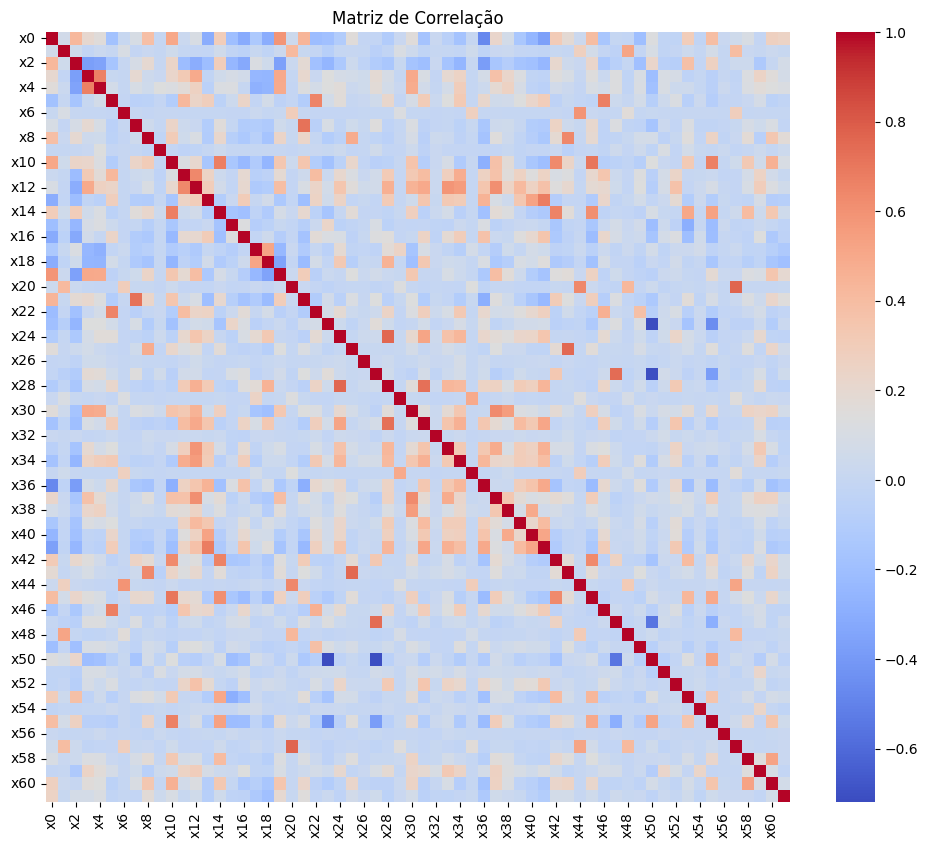

In [5]:
amostra = criar_amostra(df)

print("\nTamanho da amostra:", len(amostra))
print("Distribuição das classes na amostra:")
print(amostra['y'].value_counts(normalize=True))

corr_matrix = amostra.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()
plt.close()

In [6]:
estrategias = ['media', 'mediana', 'moda', 'constante']
dfs_tratados = {estrategia: tratar_nulos(amostra, estrategia) for estrategia in estrategias}
dfs_tratados.update({"analise de colunas": amostra_tratada})

for estrategia, df_tratado in dfs_tratados.items():
    print(f"\nEstatísticas após tratamento com {estrategia}:")
    print(df_tratado.describe())


Estatísticas após tratamento com media:
                 x0            x1            x2            x3            x4  \
count  15204.000000  1.520400e+04  15204.000000  15204.000000  15204.000000   
mean       0.653931  1.023735e-03      0.192747      0.066219      0.163481   
std        0.253006  8.745347e-03      0.192866      0.053267      0.121143   
min        0.000000  0.000000e+00      0.000000      0.000000      0.000000   
25%        0.500000  2.391408e-07      0.040816      0.047119      0.071948   
50%        0.700000  5.020012e-07      0.120794      0.066219      0.137355   
75%        0.833333  1.082169e-06      0.291709      0.066219      0.225291   
max        1.000000  7.197661e-01      0.934579      1.000000      0.996366   

                 x5            x6            x7            x8            x9  \
count  15204.000000  1.520400e+04  15204.000000  15204.000000  15204.000000   
mean       0.007932  3.290363e-04      0.722095      0.578417      0.329110   
std       

In [8]:
dados_preparados = {}
for estrategia, df_tratado in dfs_tratados.items():
    dados_preparados[estrategia] = preparar_dados(df_tratado, aplicar_pca=False)
    dados_preparados[f"{estrategia}_pca"] = preparar_dados(df_tratado, aplicar_pca=True)

for nome, dados in dados_preparados.items():
    X_train, X_test, y_train, y_test = dados
    print(f"\nEstatísticas para {nome}:")
    print(f"Forma de X_train: {X_train.shape}")
    print(f"Forma de X_test: {X_test.shape}")
    print(f"Distribuição de classes em y_train: {np.bincount(y_train)}")
    print(f"Distribuição de classes em y_test: {np.bincount(y_test)}")

Número de componentes PCA: 46
Número de componentes PCA: 46
Número de componentes PCA: 46
Número de componentes PCA: 46
Número de componentes PCA: 46

Estatísticas para media:
Forma de X_train: (20828, 61)
Forma de X_test: (3041, 61)
Distribuição de classes em y_train: [10414 10414]
Distribuição de classes em y_test: [ 437 2604]

Estatísticas para media_pca:
Forma de X_train: (20828, 46)
Forma de X_test: (3041, 46)
Distribuição de classes em y_train: [10414 10414]
Distribuição de classes em y_test: [ 437 2604]

Estatísticas para mediana:
Forma de X_train: (20828, 61)
Forma de X_test: (3041, 61)
Distribuição de classes em y_train: [10414 10414]
Distribuição de classes em y_test: [ 437 2604]

Estatísticas para mediana_pca:
Forma de X_train: (20828, 46)
Forma de X_test: (3041, 46)
Distribuição de classes em y_train: [10414 10414]
Distribuição de classes em y_test: [ 437 2604]

Estatísticas para moda:
Forma de X_train: (20828, 61)
Forma de X_test: (3041, 61)
Distribuição de classes em y_tr


Treinando modelos com estratégia: media

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 137.15 segundos
Avaliação do Random Forest (Estratégia de preparação: media):
Acurácia: 0.8609
Precisão: 0.8921
Recall: 0.9528
F1-Score: 0.9214
AUC-ROC: 0.7561
Precisão_Classe_0: 0.5269
Recall_Classe_0: 0.3135
F1-Score_Classe_0: 0.3931
Precisão_Classe_1: 0.8921
Recall_Classe_1: 0.9528
F1-Score_Classe_1: 0.9214


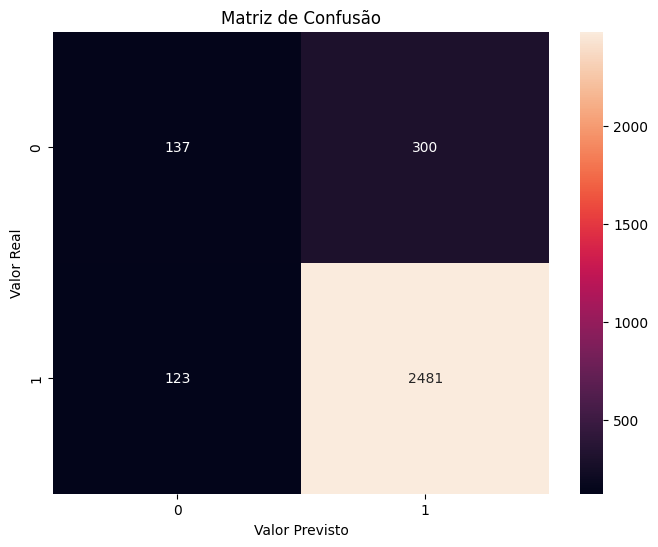


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 12.01 segundos
Avaliação do XGBoost (Estratégia de preparação: media):
Acurácia: 0.8589
Precisão: 0.8869
Recall: 0.9574
F1-Score: 0.9208
AUC-ROC: 0.7081
Precisão_Classe_0: 0.5174
Recall_Classe_0: 0.2723
F1-Score_Classe_0: 0.3568
Precisão_Classe_1: 0.8869
Recall_Classe_1: 0.9574
F1-Score_Classe_1: 0.9208


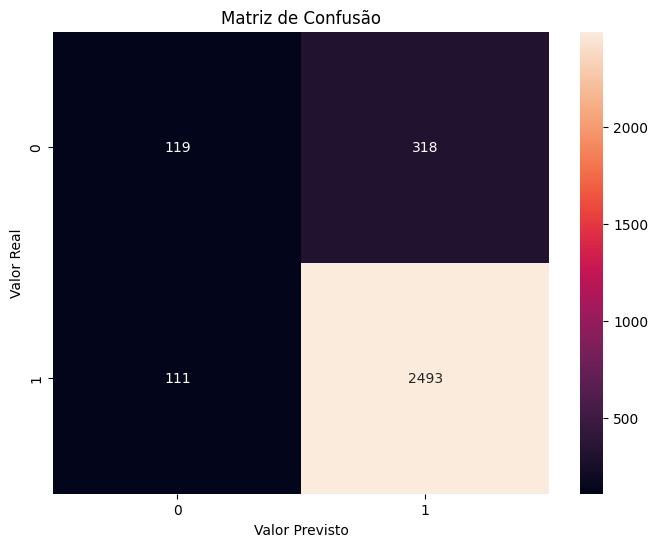


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15549
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

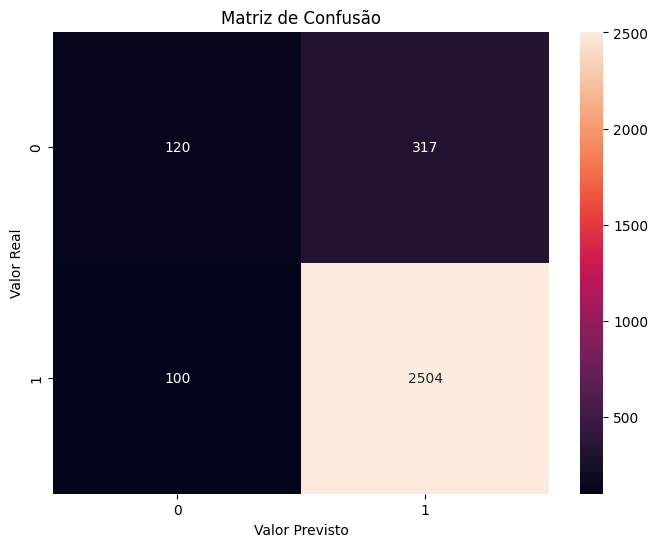


Treinando modelos com estratégia: media_pca

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 155.48 segundos
Avaliação do Random Forest (Estratégia de preparação: media_pca):
Acurácia: 0.8395
Precisão: 0.8898
Recall: 0.9274
F1-Score: 0.9082
AUC-ROC: 0.7182
Precisão_Classe_0: 0.4220
Recall_Classe_0: 0.3158
F1-Score_Classe_0: 0.3613
Precisão_Classe_1: 0.8898
Recall_Classe_1: 0.9274
F1-Score_Classe_1: 0.9082


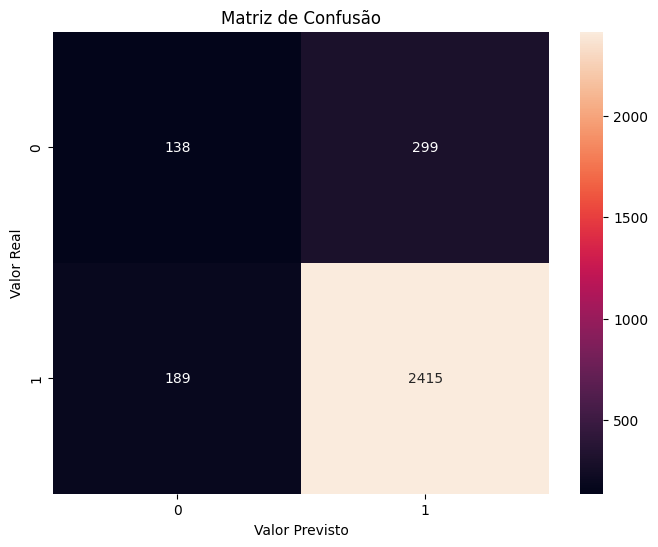


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 11.30 segundos
Avaliação do XGBoost (Estratégia de preparação: media_pca):
Acurácia: 0.8060
Precisão: 0.8891
Recall: 0.8836
F1-Score: 0.8864
AUC-ROC: 0.6720
Precisão_Classe_0: 0.3311
Recall_Classe_0: 0.3432
F1-Score_Classe_0: 0.3371
Precisão_Classe_1: 0.8891
Recall_Classe_1: 0.8836
F1-Score_Classe_1: 0.8864


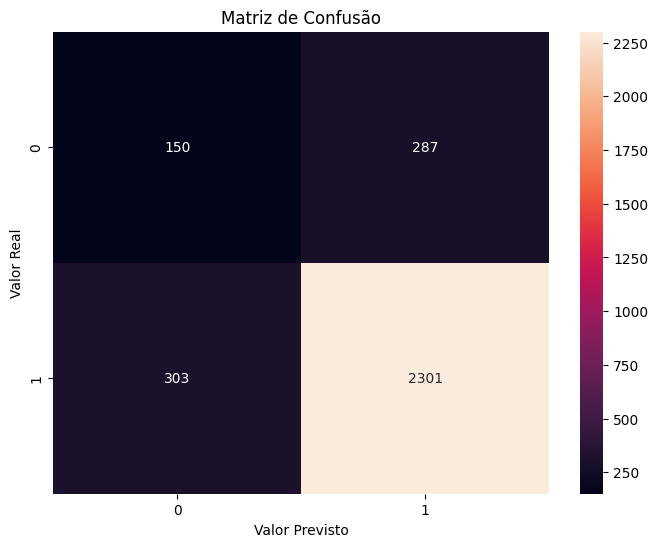


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

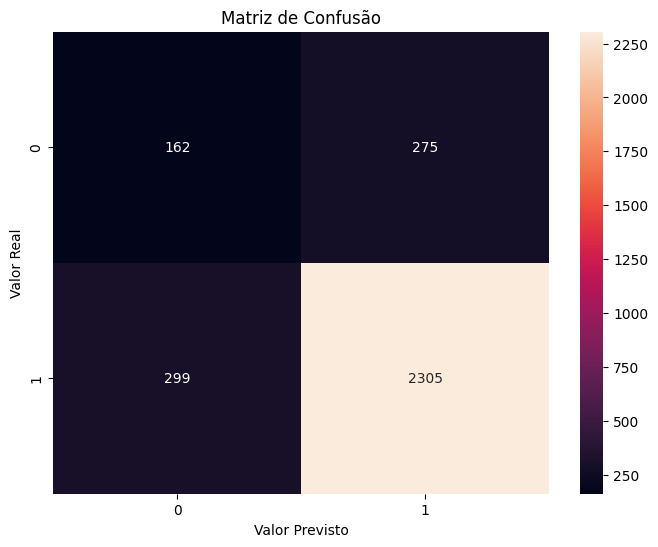


Treinando modelos com estratégia: mediana

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 139.88 segundos
Avaliação do Random Forest (Estratégia de preparação: mediana):
Acurácia: 0.8530
Precisão: 0.8886
Recall: 0.9470
F1-Score: 0.9169
AUC-ROC: 0.7549
Precisão_Classe_0: 0.4812
Recall_Classe_0: 0.2929
F1-Score_Classe_0: 0.3642
Precisão_Classe_1: 0.8886
Recall_Classe_1: 0.9470
F1-Score_Classe_1: 0.9169


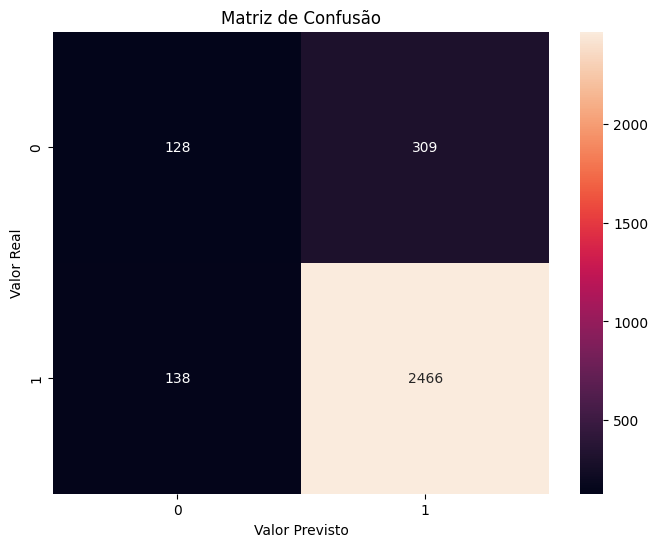


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 11.13 segundos
Avaliação do XGBoost (Estratégia de preparação: mediana):
Acurácia: 0.8533
Precisão: 0.8859
Recall: 0.9512
F1-Score: 0.9174
AUC-ROC: 0.7124
Precisão_Classe_0: 0.4816
Recall_Classe_0: 0.2700
F1-Score_Classe_0: 0.3460
Precisão_Classe_1: 0.8859
Recall_Classe_1: 0.9512
F1-Score_Classe_1: 0.9174


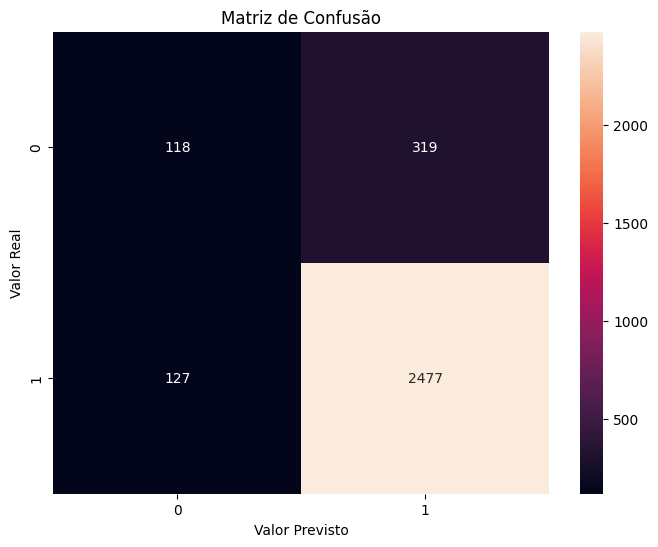


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15550
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1}
Tempo de treinamento: 14.79 segundos
Avaliação do LightGBM (Estratégia de preparação: mediana):
Acurácia: 0.8645
Precisão: 0.8851
Recall: 0.9674
F1-Score: 0.9244
AUC-ROC: 0.7361
Precisão_Classe_0: 0.5641
Recall_Classe_0: 0.2517
F1-Score_Classe_0: 0.3481
Precisão_Classe_1: 0.8851
Recall_Classe_1: 0.9674
F1-Score_Classe_1: 0.9244


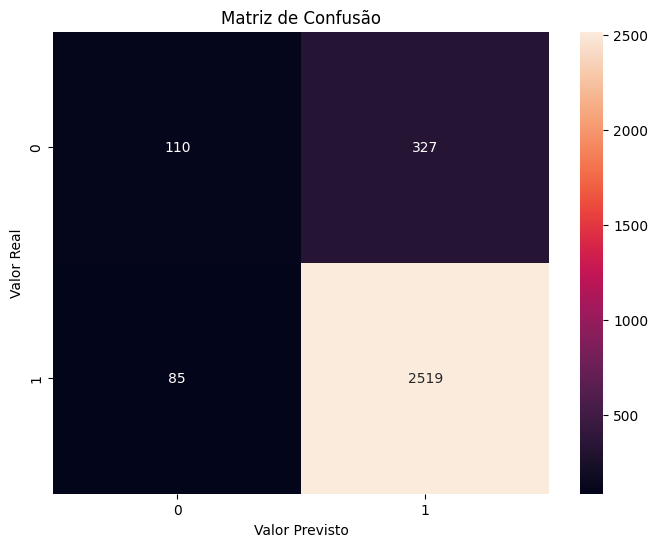


Treinando modelos com estratégia: mediana_pca

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 149.57 segundos
Avaliação do Random Forest (Estratégia de preparação: mediana_pca):
Acurácia: 0.8346
Precisão: 0.8892
Recall: 0.9217
F1-Score: 0.9051
AUC-ROC: 0.7238
Precisão_Classe_0: 0.4035
Recall_Classe_0: 0.3158
F1-Score_Classe_0: 0.3543
Precisão_Classe_1: 0.8892
Recall_Classe_1: 0.9217
F1-Score_Classe_1: 0.9051


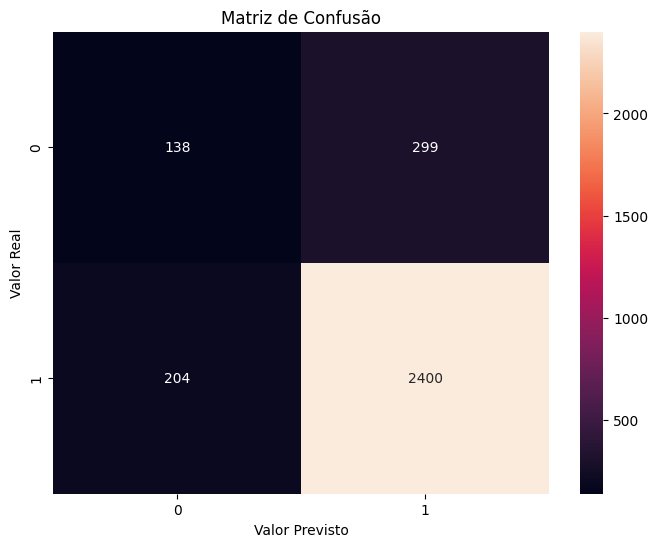


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 11.14 segundos
Avaliação do XGBoost (Estratégia de preparação: mediana_pca):
Acurácia: 0.8073
Precisão: 0.8932
Recall: 0.8802
F1-Score: 0.8867
AUC-ROC: 0.6873
Precisão_Classe_0: 0.3432
Recall_Classe_0: 0.3730
F1-Score_Classe_0: 0.3575
Precisão_Classe_1: 0.8932
Recall_Classe_1: 0.8802
F1-Score_Classe_1: 0.8867


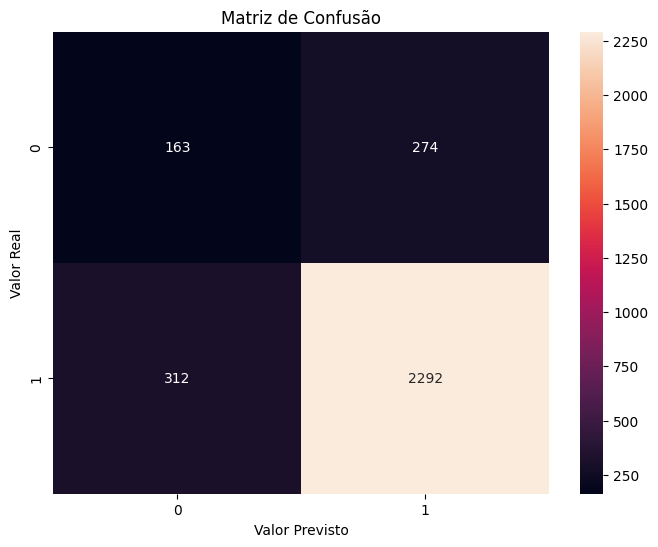


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

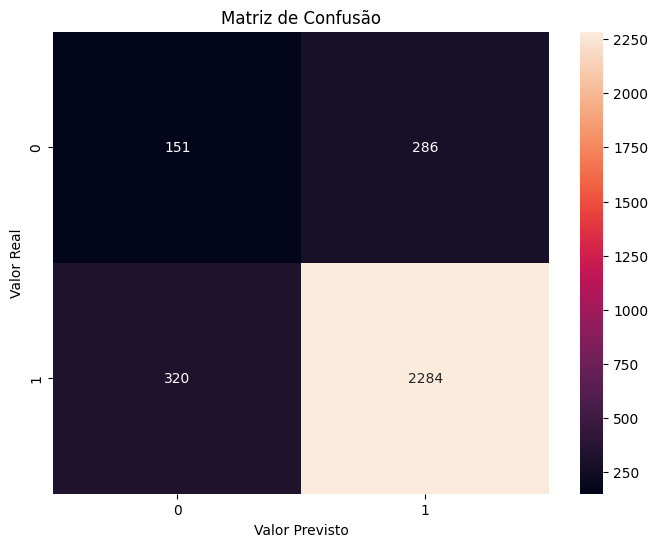


Treinando modelos com estratégia: moda

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 120.36 segundos
Avaliação do Random Forest (Estratégia de preparação: moda):
Acurácia: 0.8468
Precisão: 0.8956
Recall: 0.9293
F1-Score: 0.9122
AUC-ROC: 0.7590
Precisão_Classe_0: 0.4572
Recall_Classe_0: 0.3547
F1-Score_Classe_0: 0.3995
Precisão_Classe_1: 0.8956
Recall_Classe_1: 0.9293
F1-Score_Classe_1: 0.9122


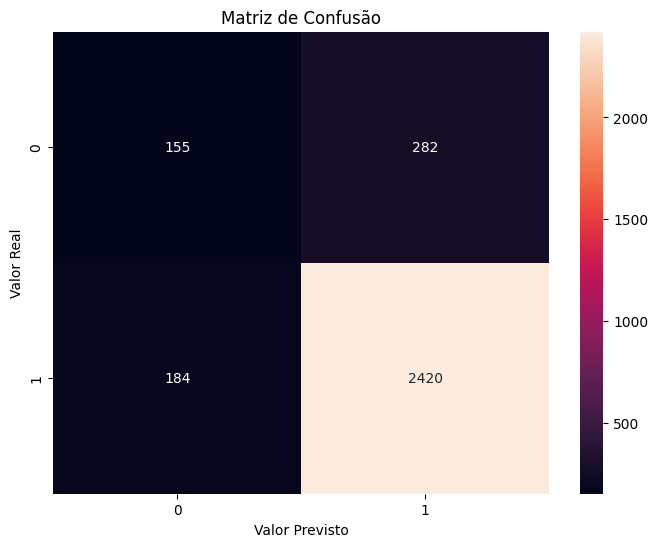


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 11.09 segundos
Avaliação do XGBoost (Estratégia de preparação: moda):
Acurácia: 0.8504
Precisão: 0.8853
Recall: 0.9482
F1-Score: 0.9156
AUC-ROC: 0.7207
Precisão_Classe_0: 0.4643
Recall_Classe_0: 0.2677
F1-Score_Classe_0: 0.3396
Precisão_Classe_1: 0.8853
Recall_Classe_1: 0.9482
F1-Score_Classe_1: 0.9156


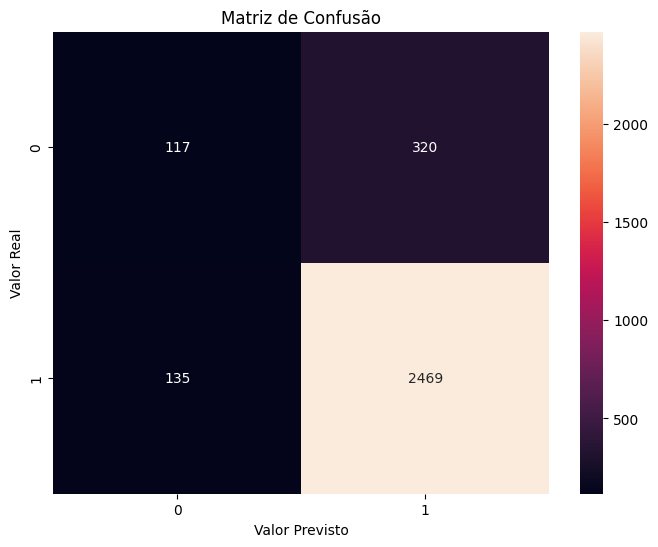


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15554
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1}
Tempo de treinamento: 13.13 segundos
Avaliação do LightGBM (Estratégia de preparação: moda):
Acurácia: 0.8606
Precisão: 0.8857
Recall: 0.9612
F1-Score: 0.9219
AUC-ROC: 0.7433
Precisão_Classe_0: 0.5302
Recall_Classe_0: 0.2609
F1-Score_Classe_0: 0.3497
Precisão_Classe_1: 0.8857
Recall_Classe_1: 0.9612
F1-Score_Classe_1: 0.9219


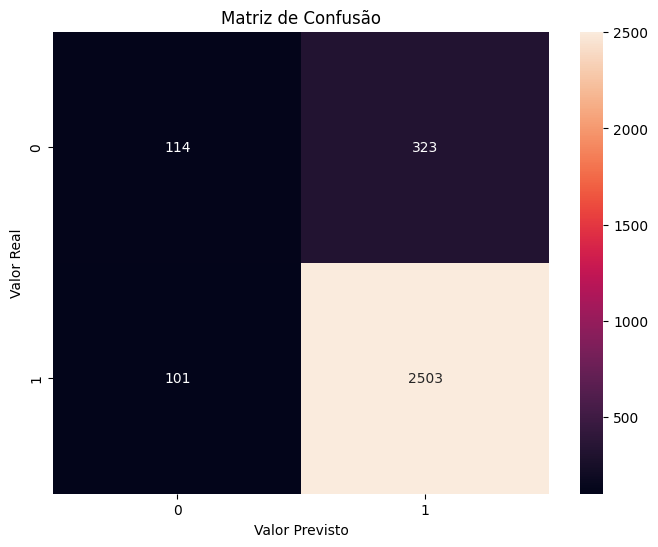


Treinando modelos com estratégia: moda_pca

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 143.57 segundos
Avaliação do Random Forest (Estratégia de preparação: moda_pca):
Acurácia: 0.8339
Precisão: 0.8883
Recall: 0.9220
F1-Score: 0.9048
AUC-ROC: 0.7148
Precisão_Classe_0: 0.3994
Recall_Classe_0: 0.3089
F1-Score_Classe_0: 0.3484
Precisão_Classe_1: 0.8883
Recall_Classe_1: 0.9220
F1-Score_Classe_1: 0.9048


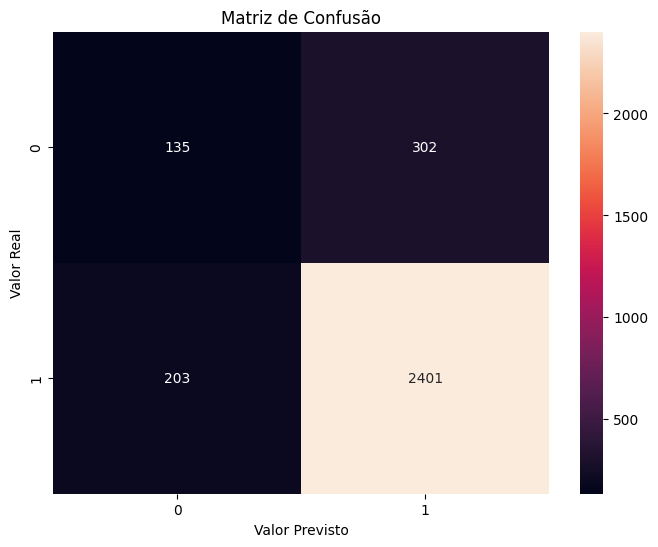


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 10.77 segundos
Avaliação do XGBoost (Estratégia de preparação: moda_pca):
Acurácia: 0.8047
Precisão: 0.8868
Recall: 0.8848
F1-Score: 0.8858
AUC-ROC: 0.6787
Precisão_Classe_0: 0.3228
Recall_Classe_0: 0.3272
F1-Score_Classe_0: 0.3250
Precisão_Classe_1: 0.8868
Recall_Classe_1: 0.8848
F1-Score_Classe_1: 0.8858


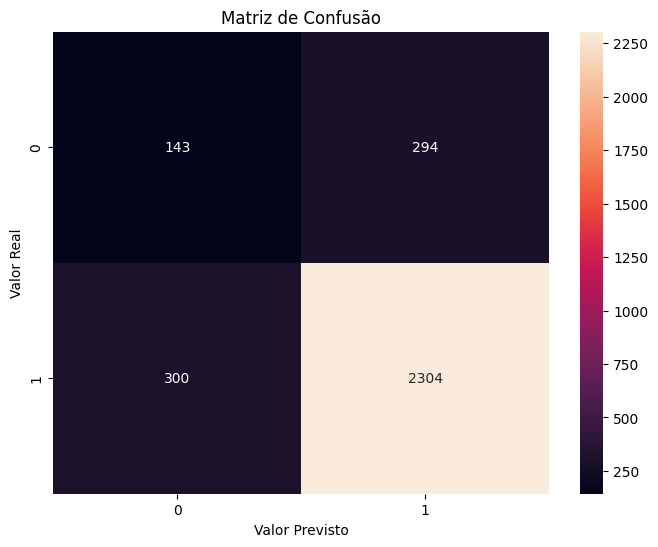


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

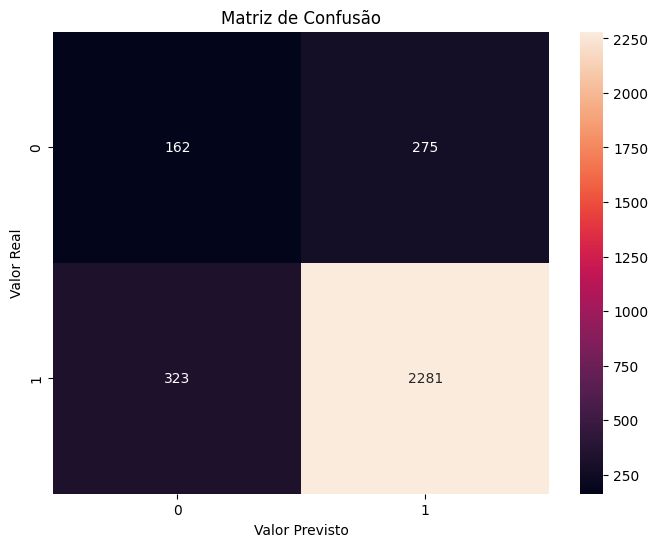


Treinando modelos com estratégia: constante

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 120.21 segundos
Avaliação do Random Forest (Estratégia de preparação: constante):
Acurácia: 0.8504
Precisão: 0.8981
Recall: 0.9309
F1-Score: 0.9142
AUC-ROC: 0.7632
Precisão_Classe_0: 0.4737
Recall_Classe_0: 0.3707
F1-Score_Classe_0: 0.4159
Precisão_Classe_1: 0.8981
Recall_Classe_1: 0.9309
F1-Score_Classe_1: 0.9142


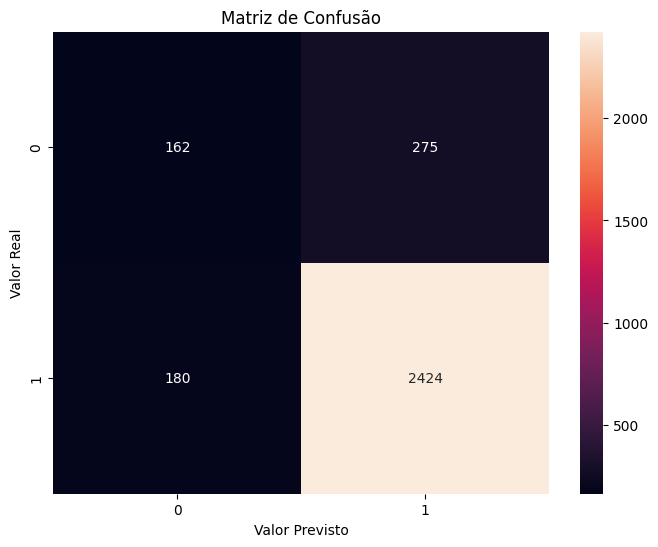


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 12.17 segundos
Avaliação do XGBoost (Estratégia de preparação: constante):
Acurácia: 0.8547
Precisão: 0.8875
Recall: 0.9508
F1-Score: 0.9181
AUC-ROC: 0.7136
Precisão_Classe_0: 0.4900
Recall_Classe_0: 0.2815
F1-Score_Classe_0: 0.3576
Precisão_Classe_1: 0.8875
Recall_Classe_1: 0.9508
F1-Score_Classe_1: 0.9181


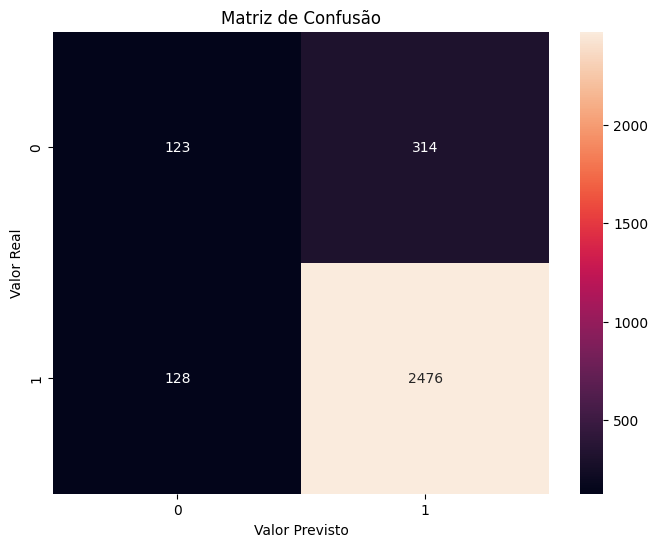


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15551
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

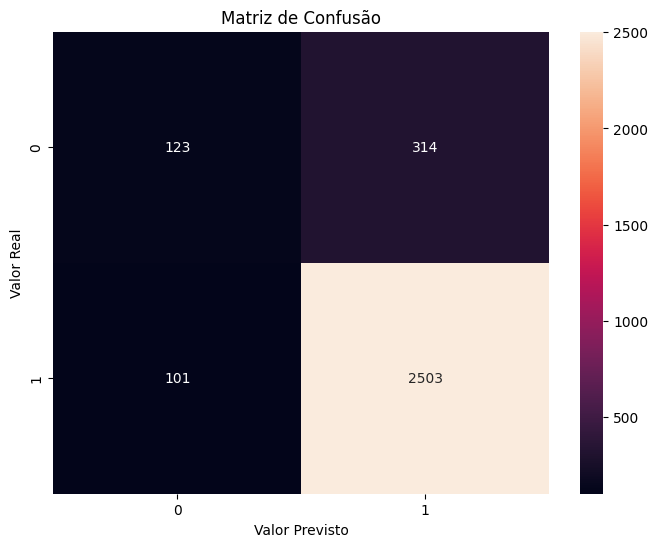


Treinando modelos com estratégia: constante_pca

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 143.23 segundos
Avaliação do Random Forest (Estratégia de preparação: constante_pca):
Acurácia: 0.8359
Precisão: 0.8935
Recall: 0.9178
F1-Score: 0.9055
AUC-ROC: 0.7414
Precisão_Classe_0: 0.4153
Recall_Classe_0: 0.3478
F1-Score_Classe_0: 0.3786
Precisão_Classe_1: 0.8935
Recall_Classe_1: 0.9178
F1-Score_Classe_1: 0.9055


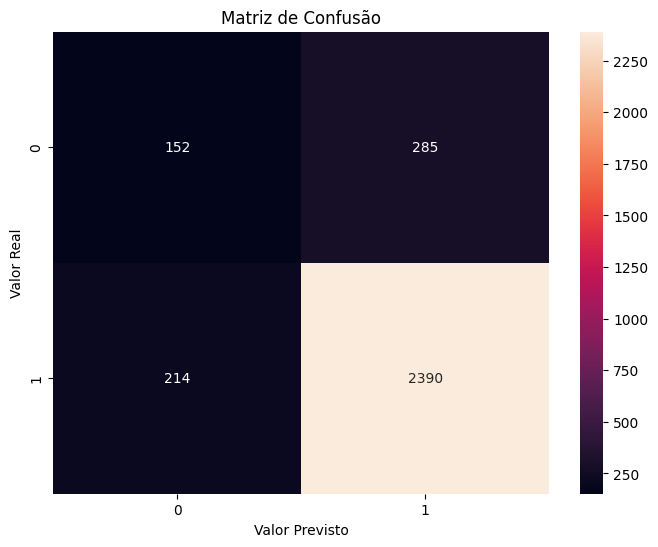


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 11.46 segundos
Avaliação do XGBoost (Estratégia de preparação: constante_pca):
Acurácia: 0.8066
Precisão: 0.8913
Recall: 0.8817
F1-Score: 0.8865
AUC-ROC: 0.6944
Precisão_Classe_0: 0.3376
Recall_Classe_0: 0.3593
F1-Score_Classe_0: 0.3481
Precisão_Classe_1: 0.8913
Recall_Classe_1: 0.8817
F1-Score_Classe_1: 0.8865


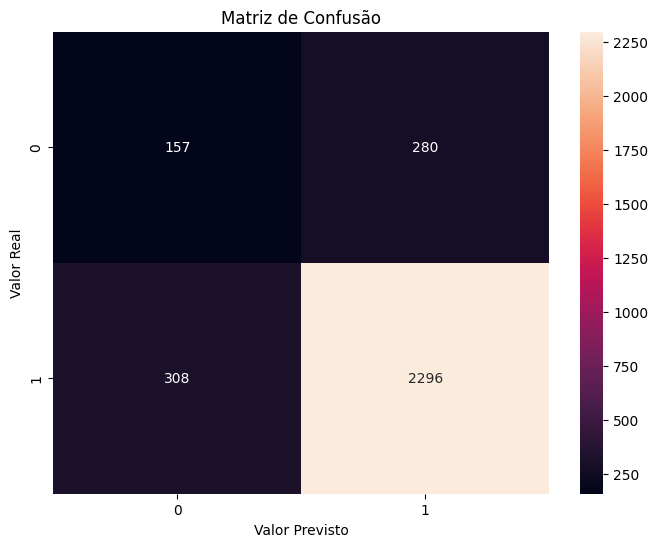


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

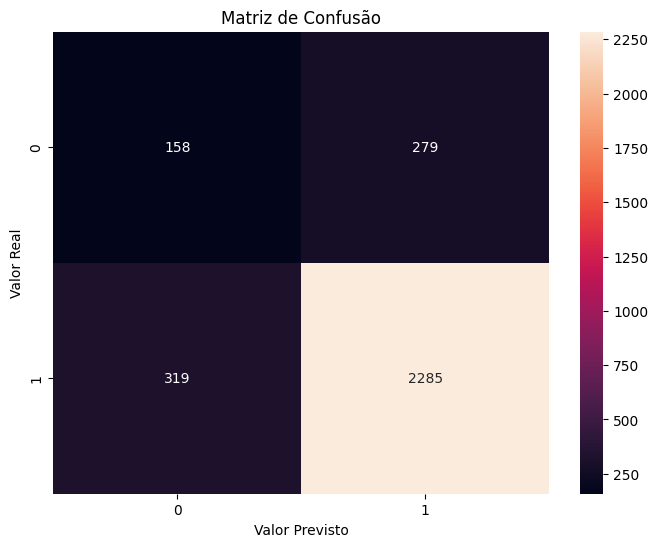


Treinando modelos com estratégia: analise de colunas

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 132.18 segundos
Avaliação do Random Forest (Estratégia de preparação: analise de colunas):
Acurácia: 0.8484
Precisão: 0.8878
Recall: 0.9420
F1-Score: 0.9141
AUC-ROC: 0.7497
Precisão_Classe_0: 0.4549
Recall_Classe_0: 0.2890
F1-Score_Classe_0: 0.3534
Precisão_Classe_1: 0.8878
Recall_Classe_1: 0.9420
F1-Score_Classe_1: 0.9141


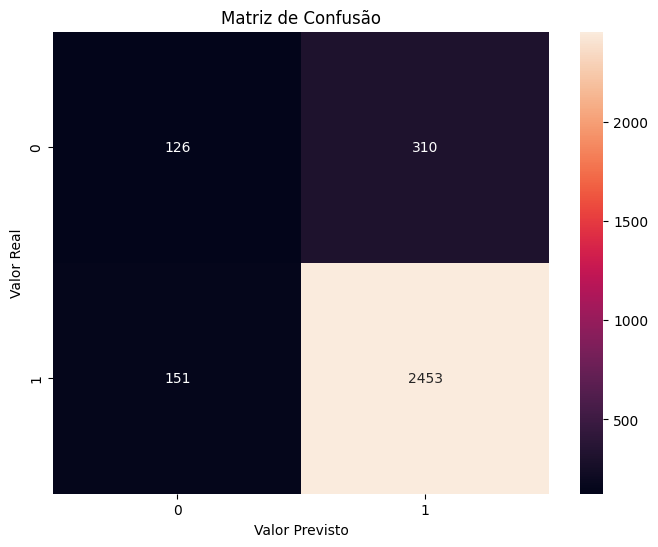


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 11.31 segundos
Avaliação do XGBoost (Estratégia de preparação: analise de colunas):
Acurácia: 0.8530
Precisão: 0.8834
Recall: 0.9543
F1-Score: 0.9175
AUC-ROC: 0.7064
Precisão_Classe_0: 0.4758
Recall_Classe_0: 0.2477
F1-Score_Classe_0: 0.3258
Precisão_Classe_1: 0.8834
Recall_Classe_1: 0.9543
F1-Score_Classe_1: 0.9175


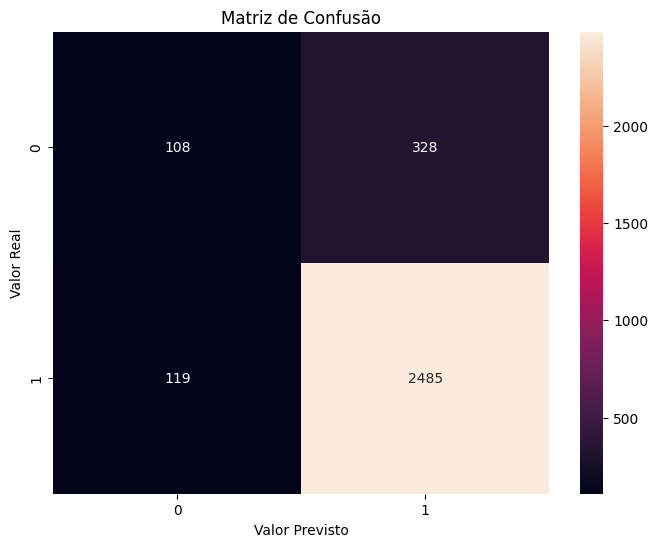


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10413, number of negative: 10413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15550
[LightGBM] [Info] Number of data points in the train set: 20826, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'num_leaves': 50, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1}
Tempo de treinamento: 17.91 segundos
Avaliação do LightGBM (Estratégia de preparação: analise de colunas):
Acurácia: 0.8651
Precisão: 0.8828
Recall: 0.9716
F1-Score: 0.9250
AUC-ROC: 0.7323
Precisão_Classe_0: 0.5747
Recall_Classe_0: 0.2294
F1-Score_Classe_0: 0.3279
Precisão_Classe_1: 0.8828
Recall_Classe_1: 0.9716
F1-Score_Classe_1: 0.9250


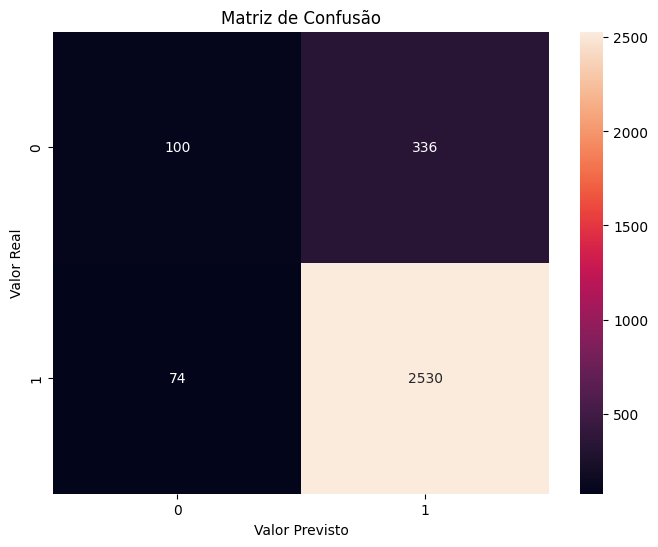


Treinando modelos com estratégia: analise de colunas_pca

Otimizando e treinando Random Forest...
Melhores parâmetros para Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tempo de treinamento: 148.53 segundos
Avaliação do Random Forest (Estratégia de preparação: analise de colunas_pca):
Acurácia: 0.8365
Precisão: 0.8849
Recall: 0.9301
F1-Score: 0.9069
AUC-ROC: 0.7164
Precisão_Classe_0: 0.3993
Recall_Classe_0: 0.2775
F1-Score_Classe_0: 0.3275
Precisão_Classe_1: 0.8849
Recall_Classe_1: 0.9301
F1-Score_Classe_1: 0.9069


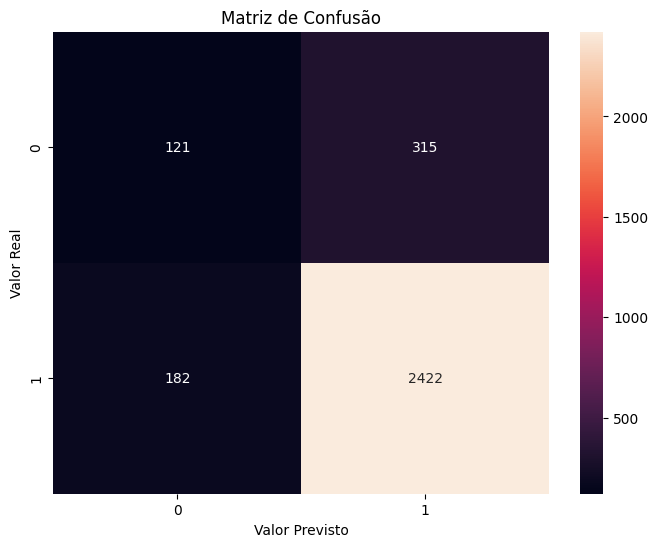


Otimizando e treinando XGBoost...
Melhores parâmetros para XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}
Tempo de treinamento: 11.57 segundos
Avaliação do XGBoost (Estratégia de preparação: analise de colunas_pca):
Acurácia: 0.8023
Precisão: 0.8892
Recall: 0.8786
F1-Score: 0.8839
AUC-ROC: 0.6862
Precisão_Classe_0: 0.3233
Recall_Classe_0: 0.3463
F1-Score_Classe_0: 0.3344
Precisão_Classe_1: 0.8892
Recall_Classe_1: 0.8786
F1-Score_Classe_1: 0.8839


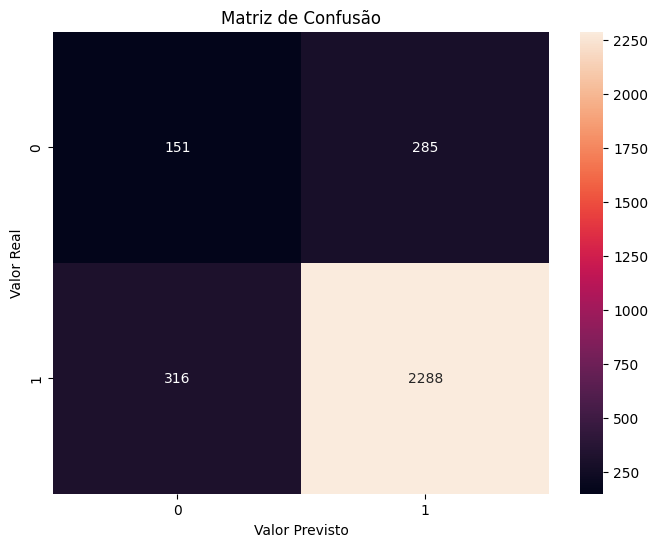


Otimizando e treinando LightGBM...
[LightGBM] [Info] Number of positive: 10413, number of negative: 10413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 20826, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

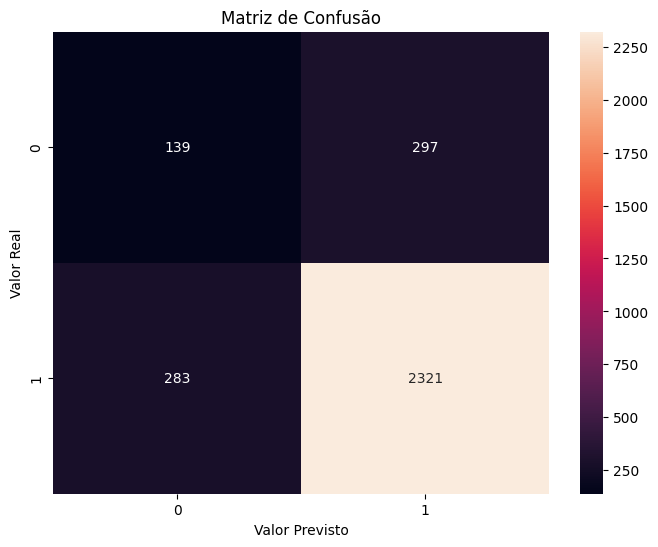


Todos os resultados foram salvos em 'resultados_modelos.parquet'


In [9]:
todos_resultados = []
modelos_treinados = {}

for estrategia, (X_train, X_test, y_train, y_test) in dados_preparados.items():
    print(f"\nTreinando modelos com estratégia: {estrategia}")
    resultados, modelos = treinar_e_avaliar(X_train, X_test, y_train, y_test, estrategia)
    todos_resultados.extend(resultados)
    modelos_treinados[estrategia] = modelos

df_todos_resultados = pd.DataFrame(todos_resultados)
df_todos_resultados.to_parquet('resultados_modelos.parquet')

print("\nTodos os resultados foram salvos em 'resultados_modelos.parquet'")

[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15549
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10414, number of negative: 10414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15550
[LightGBM] [Info] Number of data points in the train set: 20828, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10413, number of negative: 10413
[LightGBM] [Info] Auto-choosing col-wise multi-th

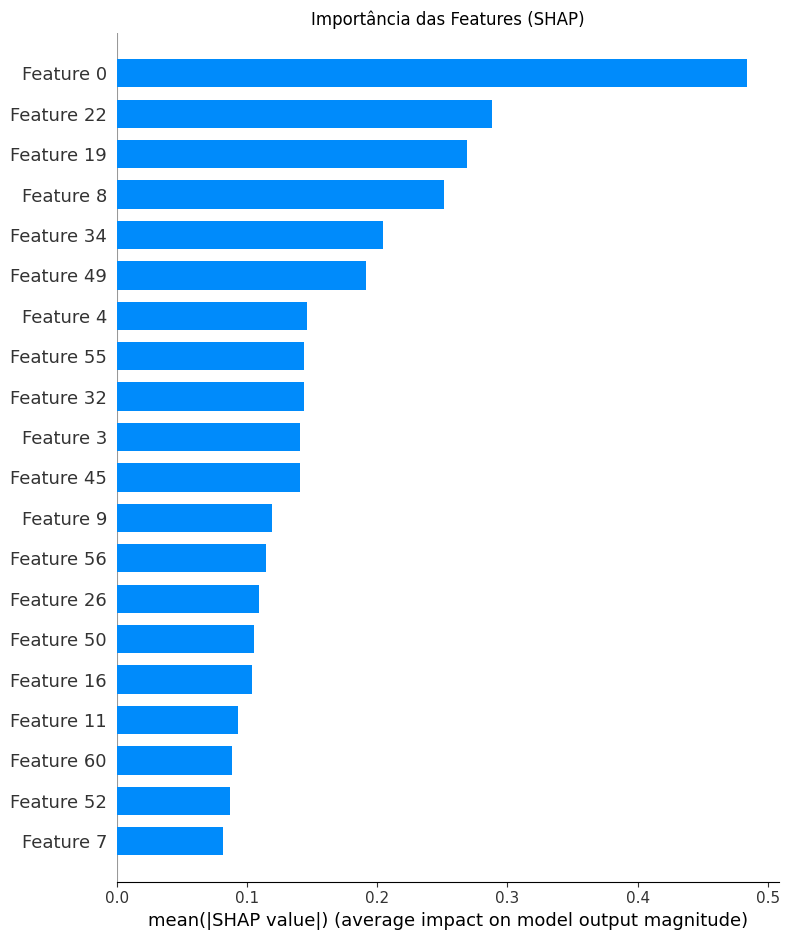

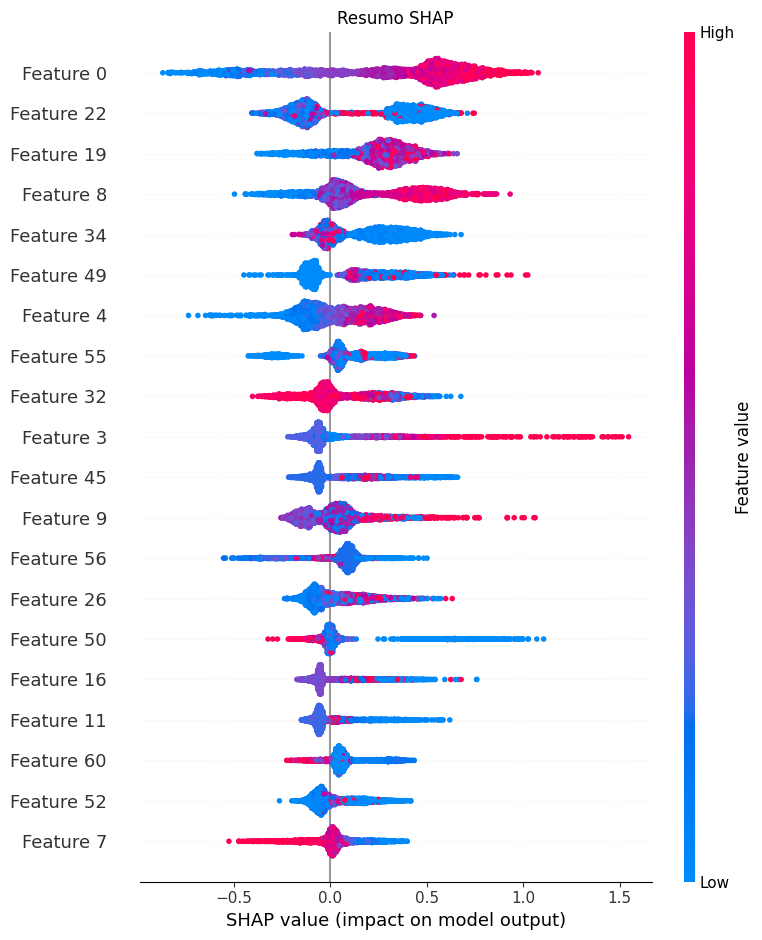

In [13]:
melhor_estrategia, melhor_nome, melhor_modelo, melhor_pontuacao, melhor_acuracia, melhor_precisao_0, melhor_precisao_1 = selecionar_melhor_modelo(todos_resultados, dados_preparados)

print(f"\nMelhor modelo: {melhor_nome} com estratégia {melhor_estrategia}")
print(f"Pontuação média: {melhor_pontuacao:.4f}")
print(f"Acurácia: {melhor_acuracia:.4f}")
print(f"Precisão Classe 0: {melhor_precisao_0:.4f}")
print(f"Precisão Classe 1: {melhor_precisao_1:.4f}")

# Continuar com a análise SHAP
X_test = dados_preparados[melhor_estrategia][1]
explainer = shap.TreeExplainer(melhor_modelo)
shap_values = explainer.shap_values(X_test)

# Plotar o gráfico de barras SHAP
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Importância das Features (SHAP)")
plt.tight_layout()
plt.show()

# Plotar o gráfico de resumo SHAP
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Resumo SHAP")
plt.tight_layout()
plt.show()

In [11]:
#predicoes, modelo_final, y_pred_final = treinar_e_prever_modelo_final(df, test, melhor_modelo, melhor_estrategia, tratar_nulos)
predicoes, modelo_final, y_pred_final = treinar_e_prever_modelo_final(df_limpo, test, melhor_modelo, melhor_estrategia, tratar_nulos)

print("\nPrevisões finais geradas e modelo final treinado.")


Treinando modelo final com todos os dados...
[LightGBM] [Info] Number of positive: 130173, number of negative: 130173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15549
[LightGBM] [Info] Number of data points in the train set: 260346, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Aviso: A coluna 'id' não está presente no DataFrame de teste.
Salvando as previsões com o índice como identificador...
Previsões finais salvas em 'predicoes_finais.csv' com o índice como identificador.

Previsões finais geradas e modelo final treinado.



Testando o modelo final com o conjunto de teste...
Acurácia: 0.8023
Precisão: 0.8121
Recall: 0.9702
F1-Score: 0.8842


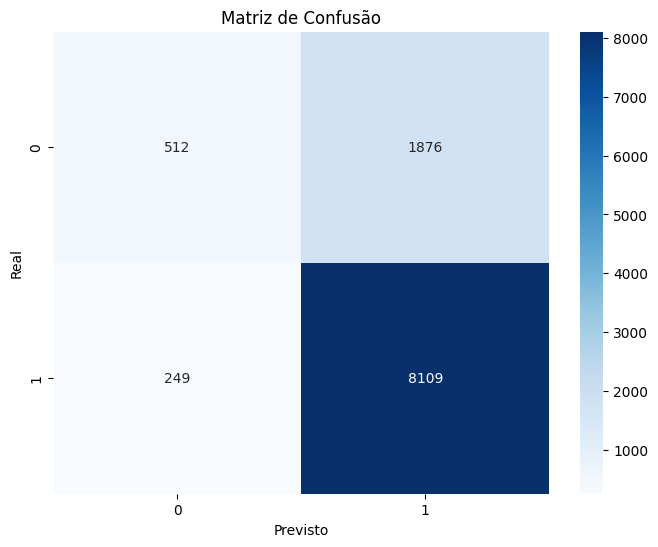


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.67      0.21      0.33      2388
           1       0.81      0.97      0.88      8358

    accuracy                           0.80     10746
   macro avg       0.74      0.59      0.60     10746
weighted avg       0.78      0.80      0.76     10746


Total de amostras: 10746
Acertos: 8621 (80.23%)
Erros: 2125 (19.77%)


In [12]:
avaliar_modelo_final(y_pred_final, test)